In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

C:\Users\Deniz\AppData\Local\Temp\ipykernel_17196\920911837.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
localhost_name = 'localhost'

db_params = {
    'host': localhost_name,
    'database': 'thesisdb',
    'user': 'postgres',
    'password': 'admin',
    'port': '5432'
}

table_name = 'transactions_small'
engine = create_engine(f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['database']}")


In [ ]:
# Private tx inspection. Timepending == 0 or do we need more complex analysis?
def process_date(directory_name):
    accumulator_df = None

    for filename in glob.glob(f"../{directory_name}/18.csv.gz"):
        df = pd.read_csv(filename, sep='\t', compression='gzip')
        df = df[df['region'] == 'us-east-1']
        if accumulator_df is None:
            accumulator_df = df
        else:
            accumulator_df = pd.concat([accumulator_df, df], ignore_index=True)
        del df # release memory

    # Now you can use accumulator_df
    return accumulator_df

In [ ]:
def find_hashes_with_multiple_statuses(df):
    # Filter to include only 'pending' or 'confirmed' statuses
    filtered_df = df[df['status'].isin(['pending', 'confirmed'])]
    
    # Group by 'hash' and filter to those having both statuses
    # This is done by checking if the unique statuses per group are exactly 2 (i.e., 'pending' and 'confirmed')
    valid_hashes = filtered_df.groupby('hash').filter(lambda x: len(x['status'].unique()) == 2)['hash'].unique()
    
    return valid_hashes

In [ ]:
def identify_private_tx_by_multiple_status(df):
    # Group by 'hash'
    grouped = df.groupby('hash')
    
    # Define a filter function to check each group
    def filter_confirmed_only(group):
        # Check if all statuses in the group are 'confirmed' and 'pending' is not present
        statuses = group['status'].unique()
        return len(statuses) == 1 and 'confirmed' in statuses and 'pending' not in statuses
    
    # Apply the filter function to each group and get the valid hashes
    valid_hashes = grouped.filter(filter_confirmed_only)['hash'].unique()
    
    return valid_hashes

In [ ]:
def identify_private_tx_by_status_mask(df):
    # Filter to include only rows with 'confirmed' status
    confirmed_df = df[df['status'] == 'confirmed']
    
    # Find hashes with 'pending' status to exclude them
    pending_hashes = df[df['status'] == 'pending']['hash'].unique()
    
    # Filter confirmed_df to exclude any rows with hashes found in pending_hashes
    exclusive_confirmed_df = confirmed_df[~confirmed_df['hash'].isin(pending_hashes)]
    
    return exclusive_confirmed_df

In [ ]:
# csv_2021 = process_date('data/20210101')
# csv_2021
# public_tx_hashes = find_hashes_with_multiple_statuses(csv_2021)
# faulty_private_tx_hashes = identify_private_tx_by_multiple_status(csv_2021)
# private_tx_hashes = identify_private_tx_by_status_mask(csv_2021)
# sample_private_tx = csv_2021[csv_2021['hash'] == '0xabf79fbf5988d56acd0a5f9fb63d43e39f39b8c3815b22e651237bed46d1fe71']

In [ ]:
# Define your queries
query_2021 = "SELECT * FROM transactions_small WHERE detect_date = '2021-06-30';"
query_2024 = "SELECT * FROM transactions_small WHERE detect_date = '2024-02-01';"

# Use pandas.read_sql_query to execute the query and load data into DataFrame
df_2021 = pd.read_sql_query(query_2021, engine)
df_2024 = pd.read_sql_query(query_2024, engine)

In [ ]:
def plot_gas_usage(df):
        # Splitting the DataFrame into private and public based on 'timepending'
        private = df[df["timepending"] == 0]
        public = df[df["timepending"] != 0]
        print("Noncleaned public is ", public.shape[0])
        public = public.dropna(subset=['timepending'])
        print("Noncleaned public is ", public.shape[0])

        gasused_private_sum = 0

        # Calculating the sum of 'gasused' for both private and public transactions
        if private.empty:
                gasused_private_sum = 0
        else:
                gasused_private_sum = private['gasused'].sum()
                
        gasused_public_sum = public['gasused'].sum()

        # Preparing data for the pie chart
        labels = 'Private Transactions Gas Used', 'Public Transactions Gas Used'
        sizes = np.array([gasused_private_sum, gasused_public_sum])
        
        all_zeros = not np.any(sizes)
        if all_zeros:
                print("cannot plot anything! It's all zeros!")
                return 0,0
        
        explode = (0.1, 0)  # only "explode" the 1st slice (i.e., 'Private')

        # Plotting the pie chart
        plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        # Displaying the pie chart
        plt.title('Gas Used by Private vs Public Transactions In One Hour')
        plt.show()

        # Optional: return the sums for further use
        return gasused_private_sum, gasused_public_sum

In [ ]:
def plot_tx_count_ratio(df):
        # Splitting the DataFrame into private and public based on 'timepending'
        private = df[df["timepending"] == 0]
        public = df[df["timepending"] != 0]
        print("Noncleaned public is ", public.shape[0])
        public = public.dropna(subset=['timepending'])
        print("Noncleaned public is ", public.shape[0])

        # Preparing data for the pie chart
        labels = 'Private Transaction Count', 'Public Transaction Count'
        sizes = np.array([private.shape[0], public.shape[0]])
        
        all_zeros = not np.any(sizes)
        if all_zeros:
                print("cannot plot anything! It's all zeros!")
                return 0,0
        
        explode = (0.1, 0)  # only "explode" the 1st slice (i.e., 'Private')

        # Plotting the pie chart
        plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        # Displaying the pie chart
        plt.title('Gas Used by Private vs Public Transactions In One Hour')
        plt.show()

        # Optional: return the sums for further use
        return private.shape[0], public.shape[0]

In [ ]:
private_usage, public_usage = plot_gas_usage(df_2024)

In [ ]:
private_count, public_count = plot_tx_count_ratio(df_2024)

In [ ]:
# Define chunk size
chunk_size = 10000  # Adjust based on your system's memory capacity and row sizes

# Initialize counters and data list for aggregation
total_transactions = 0
private_transactions = 0
aggregated_data_list = []  # Use a list to collect data, which is more efficient for appending

chunk_number = 0

for chunk in pd.read_sql(f"SELECT * FROM {table_name} ORDER BY detect_date ASC LIMIT 100000", engine, chunksize=chunk_size):
    chunk_number += 1
    print(f"Processing chunk #{chunk_number}")
    chunk = chunk.dropna(subset=['timepending'])
    
    if not chunk.empty:
        first_date = chunk['detect_date'].iloc[0]
        last_date = chunk['detect_date'].iloc[-1]
        print(f"Processing chunk #{chunk_number} (Dates from {first_date} to {last_date})")
    else:
        print(f"Processing chunk #{chunk_number} (Empty chunk)")
        continue
    
    # Filtering logic remains the same
    private_chunk = chunk[chunk['timepending'] == 0]
    total_transactions += len(chunk)
    private_transactions += len(private_chunk)
    
    # Ensure the percentage is never below 0
    if total_transactions > 0:
        percentage_private = max((private_transactions / total_transactions) * 100, 0)
    else:
        percentage_private = 0

    # Append the data to the list
    aggregated_data_list.append({
        'detect_date': chunk['detect_date'].iloc[-1],
        'percentage_private': percentage_private
    })

# Convert the list of data into a DataFrame
aggregated_data = pd.DataFrame(aggregated_data_list)

# Convert 'detect_date' from text to datetime format
aggregated_data['detect_date'] = pd.to_datetime(aggregated_data['detect_date'])
# Now that 'detect_date' is properly formatted, find the minimum detect_date in the dataset
min_detect_date = aggregated_data['detect_date'].min()

# Plotting with adjusted settings to avoid negative percentage values
plt.figure(figsize=(15, 6))
plt.plot(aggregated_data['detect_date'], aggregated_data['percentage_private'], marker='o', linestyle='-')
plt.title('Transaction Count Versus Time')
plt.xlabel('Time')
plt.ylabel('Percentage of Private Transactions (%)')
plt.ylim(bottom=0)  # Ensure y-axis starts at 0%

# Adjust x-axis to start from the minimum detect_date
plt.xlim(left=min_detect_date)

ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set major ticks interval to every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Set major ticks format


plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('experiment_plot.png')  # Save the adjusted plot to a file


Minimum date in the dataset without NAN timepending values is:  2020-11-01 00:00:00


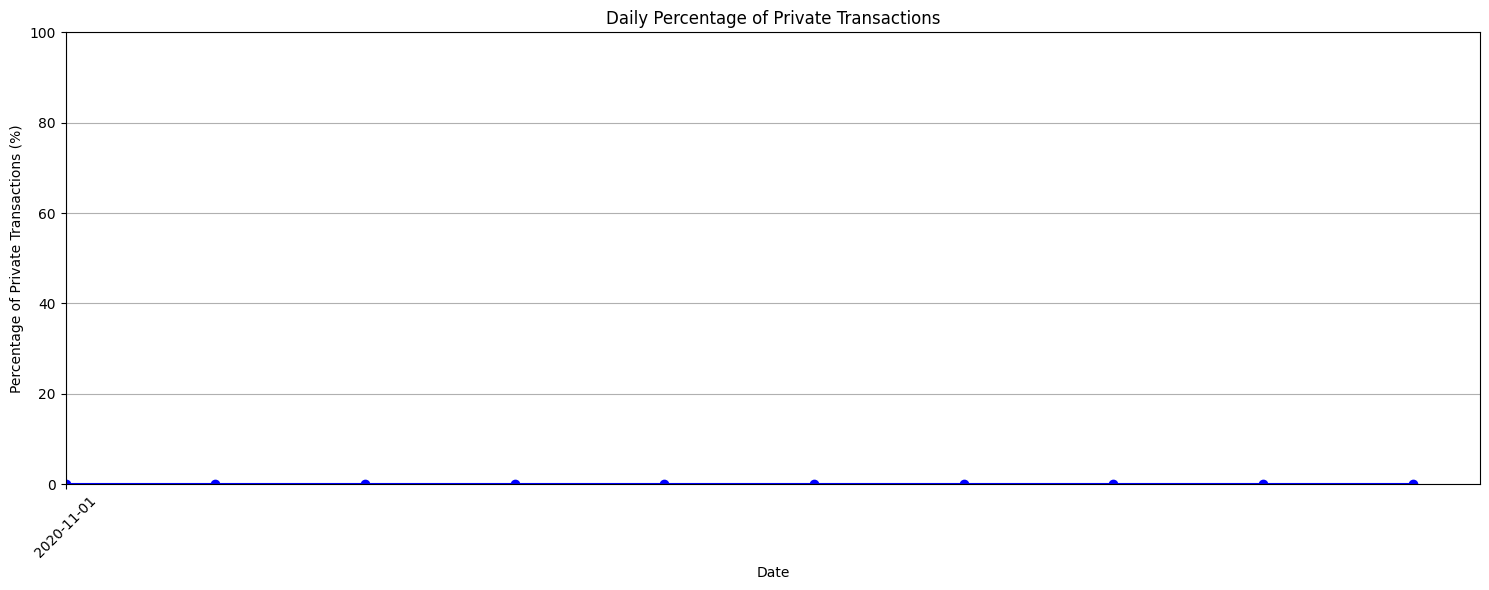

In [9]:
## TX COUNT PLOT

query_dates = f"SELECT DISTINCT detect_date FROM {table_name} ORDER BY detect_date ASC LIMIT 10"
dates = pd.read_sql(query_dates, engine)['detect_date']
print("Date query over")

# Initialize list to store daily data
daily_data_list = []

for date in dates:
    # Query to retrieve all transactions for the current date
    query_transactions = f"""
    SELECT * FROM {table_name}
    WHERE detect_date = '{date}'
    """
    transactions = pd.read_sql(query_transactions, engine)
    
    # Process transactions for the current date
    if not transactions.empty:
        total_transactions = len(transactions)
        private_transactions = len(transactions[transactions['timepending'] == 0])
        percentage_private = (private_transactions / total_transactions) * 100 if total_transactions > 0 else 0
        
        # Append the daily data to the list
        daily_data_list.append({
            'date': date,
            'percentage_private': percentage_private
        })
        
# Convert the list of daily data into a DataFrame
daily_data_df = pd.DataFrame(daily_data_list)

# Convert 'date' to datetime format for plotting
daily_data_df['date'] = pd.to_datetime(daily_data_df['date'])

min_detect_date = daily_data_df['date'].min()
print("Minimum date in the dataset without NAN timepending values is: ", min_detect_date)

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(daily_data_df['date'], daily_data_df['percentage_private'], marker='o', linestyle='-', color='blue')
plt.title('Daily Percentage of Private Transactions')
plt.xlabel('Date')
plt.ylabel('Percentage of Private Transactions (%)')
plt.ylim(0, 100)  # Percentage range

plt.xlim(left=min_detect_date)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Adjust depending on the date range
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('daily_percentage_private_transactions.png')
plt.show()

Date query over
Minimum date in the dataset without NAN timepending values is:  2020-11-08 00:00:00


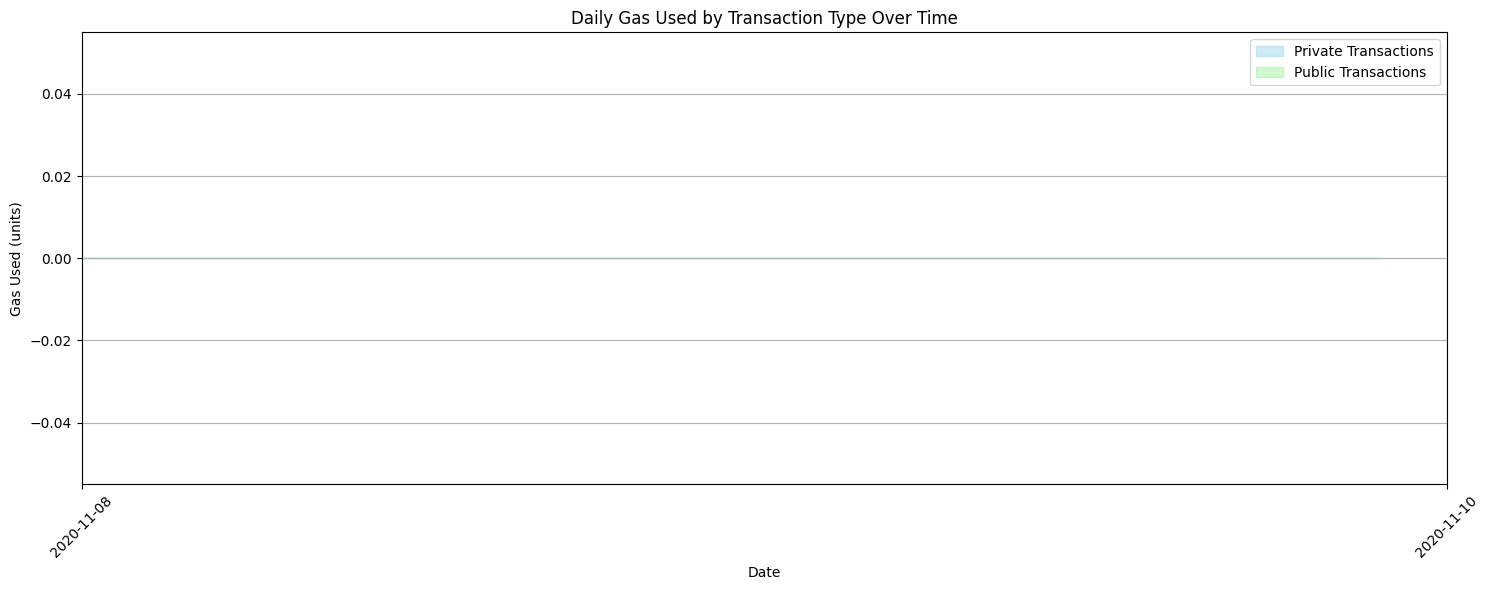

In [14]:
## GASUSED PLOT

query_dates = f"SELECT DISTINCT detect_date FROM {table_name} ORDER BY detect_date ASC LIMIT 10"
dates = pd.read_sql(query_dates, engine)['detect_date']
print("Date query over")

# Initialize list to store daily data
daily_data_list = []

for date in dates:
    # Query to retrieve all transactions for the current date
    query_transactions = f"""
    SELECT * FROM {table_name}
    WHERE detect_date = '{date}'
    """
    transactions = pd.read_sql(query_transactions, engine)
    transactions = transactions.dropna(subset=['timepending'])
    
    # Process transactions for the current date
    if not transactions.empty:
        total_gas_used_all_tx = transactions['gasused'].sum()
        private_transactions = transactions[transactions['timepending'] == 0]
        public_transactions = transactions[transactions['timepending'] != 0]
        private_tx_gasused = private_transactions['gasused'].sum()
        public_tx_gasused = total_gas_used_all_tx - private_tx_gasused

        # gas_usage_percentage_private = (private_tx_gasused / total_gas_used_all_tx) * 100 if total_gas_used_all_tx > 0 else 0
        # gas_usage_percentage_public = (public_tx_gasused / total_gas_used_all_tx) * 100 if total_gas_used_all_tx > 0 else 0
        
        # Append the daily data to the list
        daily_data_list.append({
            'date': date,
            'private_tx_gasused': private_tx_gasused,
            'public_tx_gasused': public_tx_gasused
        })
        
# Convert the list of daily data into a DataFrame
daily_data_df = pd.DataFrame(daily_data_list)

# Convert 'date' to datetime format for plotting
daily_data_df['date'] = pd.to_datetime(daily_data_df['date'])

min_detect_date = daily_data_df['date'].min()
print("Minimum date in the dataset without NAN timepending values is: ", min_detect_date)

# Plotting
plt.figure(figsize=(15, 6))
plt.fill_between(daily_data_df['date'], daily_data_df['private_tx_gasused'], color='skyblue', alpha=0.4, label='Private Transactions')
plt.fill_between(daily_data_df['date'], daily_data_df['private_tx_gasused'], daily_data_df['private_tx_gasused'] + daily_data_df['public_tx_gasused'], color='lightgreen', alpha=0.4, label='Public Transactions')

plt.title('Daily Gas Used by Transaction Type Over Time')
plt.xlabel('Date')
plt.ylabel('Gas Used (units)')
plt.xlim(left=min_detect_date)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Adjust depending on the date range
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('daily_gasused_by_transaction_type_area_chart.png')
plt.show()

In [2]:
##### Transactions table and zeromev table knowledge combination:

# Expanded sample data for transactions (Table 1)
data_transactions = {
    'curblocknumber': [101, 102, 103, 101, 104, 101, 103],
    'detect_date': ['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-01', '2021-01-05', '2021-01-01', '2021-01-03'],
    'transaction_id': [1, 2, 3, 4, 5, 6, 7],
    'amount': [100, 150, 200, 110, 120, 130, 210]
}

# Sample data for zeromev_data (Table 2)
data_zeromev = {
    'block_number': [101, 103, 105],
    'mev_tx_count': [10, 20, 30]
}

# Create DataFrames
df_transactions = pd.DataFrame(data_transactions)
df_zeromev_data = pd.DataFrame(data_zeromev)

def join_data(df1, df2):
    # Join the DataFrames
    df_joined = df1.merge(df2, how='left', left_on='curblocknumber', right_on='block_number')
    
    # Optional: Drop the redundant block_number column after join
    df_joined.drop('block_number', axis=1, inplace=True)
    
    return df_joined

# Using the function
joined_data = join_data(df_transactions, df_zeromev_data)
print(joined_data)

   curblocknumber detect_date  transaction_id  amount  mev_tx_count
0             101  2021-01-01               1     100          10.0
1             102  2021-01-02               2     150           NaN
2             103  2021-01-03               3     200          20.0
3             101  2021-01-01               4     110          10.0
4             104  2021-01-05               5     120           NaN
5             101  2021-01-01               6     130          10.0
6             103  2021-01-03               7     210          20.0
